In [1]:
# 导入库，设定超参数
# coding=utf-8
from __future__ import absolute_import, division, print_function

import os
import random
import numpy as np

import torch
import torch.distributed as dist

from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
try:
    from apex import amp
    from apex.parallel import DistributedDataParallel as DDP
    has_apex = True
except ImportError:
    has_apex = False
    # raise ImportError("Please install apex from https://www.github.com/nvidia/apex to run this example.")

from models.modeling import VisionTransformer, CONFIGS
from utils.data_utils import get_loader
from utils.dist_util import *
from matplotlib import pyplot as plt
from analyse.cca_core import *
from analyse.pwcca import *

head_num = 16
def _plot_helper(arr, label=None, xlabel=None, ylabel=None):
    if label is not None:
        plt.plot(arr, lw=2.0, label=label)
        plt.legend(loc="best")
    else:
        plt.plot(arr, lw=2.0)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

/home/zijie_xin/anaconda3/envs/env_lxmert/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 确定GPU设备和model，并load参数
# Setup CUDA, GPU & distributed training
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if n_gpu > 0:
    torch.cuda.manual_seed_all(seed)


# Model & Tokenizer Setup
config = CONFIGS["ViT-B_16-h"+str(head_num)]
num_classes = 100
# 可视化参数设为True
model = VisionTransformer(config, 224, zero_head=True, num_classes=num_classes, vis=True)

PATH = "logs/cifar100/cifar100-b16h"+str(head_num)+"/cifar100-b16h"+str(head_num)+"-Latest-epoch10.pth"
checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model'])
model.cuda()
epoch = checkpoint['epoch']
max_accuracy = checkpoint['max_accuracy']
print("Load model from %s, epoch %d, max_accuracy %f" % (PATH, epoch, max_accuracy))

Load model from logs/cifar100/cifar100-b16h16/cifar100-b16h16-Latest-epoch10.pth, epoch 10, max_accuracy 90.900000


In [3]:
# 加载data
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, RandomSampler, DistributedSampler, SequentialSampler

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),  # (args.img_size, args.img_size)
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

testset = datasets.CIFAR100(root="./data", # args.data_path,
                            train=False,
                            download=True,
                            transform=transform_test)

# len(testset) = 10000
test_loader = DataLoader(testset,
                        sampler=SequentialSampler(testset),
                        batch_size=16, #?args.eval_batch_size,
                        num_workers=1,
                        pin_memory=True)
# len(test_loader) = 10000/batch_size = 625

Files already downloaded and verified


In [4]:
# model运行data生成att_mats
model.eval()
for iter, (images, target) in enumerate(test_loader):
    if iter > 0:
        break
    images = images.cuda()
    target = target.cuda()
    output, att_mats = model(images)

print(type(att_mats))
print("Testset length: ", len(att_mats))
print("Tensor shape: ", att_mats[0].shape)

w = np.zeros((12, head_num, 197*197))  # w[i, j]表示第i个layer的第j个head的attention score
for i, att_mat in enumerate(att_mats):
    # mean: [bs, head_num, 197, 197] -> [head_num, 197, 197]
    att_mat = torch.mean(att_mat, dim=0)
    # reshape: [head_num, 197, 197] -> [head_num, 197*197]
    att_mat = att_mat.reshape(head_num, -1)
    w[i] = att_mat.cpu().detach().numpy()


<class 'list'>
Testset length:  12
Tensor shape:  torch.Size([16, 16, 197, 197])


对每一层的head0,1计算平均相似度，发现随着层数的加深，相似度在明显减少。

说明层数越深，多头拆分出的feature层次越高，越抽象，多头之间越diversify

In [5]:
def all_cca(layer1, head1, layer2, head2, draw=True, isprint=True):
    acts1, acts2 = w[layer1, head1][np.newaxis, :], w[layer2, head2][np.newaxis, :]
    results = get_cca_similarity(acts1, acts2, epsilon=1e-10, verbose=False)
    if draw:
        _plot_helper(results["cca_coef1"], "all_L%d" % (layer1), "CCA Coef idx", "CCA coef value")
    if isprint:
        print("W[%d, %d] and W[%d, %d] Mean all_CCA similarity %f" % (layer1, head1, layer2, head2, np.mean(results["cca_coef1"])))
    return np.mean(results["cca_coef1"])

for i in range(12):
    all_cca(i, 0, i, 1, draw=False)
# plt.grid()

W[0, 0] and W[0, 1] Mean all_CCA similarity 0.966873
W[1, 0] and W[1, 1] Mean all_CCA similarity 0.487205
W[2, 0] and W[2, 1] Mean all_CCA similarity 0.795330
W[3, 0] and W[3, 1] Mean all_CCA similarity 0.757352
W[4, 0] and W[4, 1] Mean all_CCA similarity 0.533102
W[5, 0] and W[5, 1] Mean all_CCA similarity 0.567144
W[6, 0] and W[6, 1] Mean all_CCA similarity 0.510385
W[7, 0] and W[7, 1] Mean all_CCA similarity 0.591292
W[8, 0] and W[8, 1] Mean all_CCA similarity 0.459446
W[9, 0] and W[9, 1] Mean all_CCA similarity 0.531233
W[10, 0] and W[10, 1] Mean all_CCA similarity 0.685406
W[11, 0] and W[11, 1] Mean all_CCA similarity 0.569172


$\text{cos sim}=\dfrac{\vec{a}\cdot\vec{b}}{|\vec{a}|\cdot |\vec{b}|}\in [-1, 1] $

$\text{w[layer, head]}\in [1, 197*197]$ 

In [6]:
import torch.nn.functional as F

def cos_sim(layer1, head1, layer2, head2, isprint=True):
    vec1, vec2 = w[layer1, head1], w[layer2, head2]
    # print("activation shapes", vec1.shape, vec2.shape)
    cos_sim = vec1.dot(vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))
    if isprint:
        print("W[%d, %d] and W[%d, %d] cos similarity %f" % (layer1, head1, layer2, head2, cos_sim))
    return cos_sim

for i in range(12):
    cos_sim(i, 0, i, 1)

W[0, 0] and W[0, 1] cos similarity 0.956668
W[1, 0] and W[1, 1] cos similarity 0.545028
W[2, 0] and W[2, 1] cos similarity 0.861177
W[3, 0] and W[3, 1] cos similarity 0.767521
W[4, 0] and W[4, 1] cos similarity 0.612351
W[5, 0] and W[5, 1] cos similarity 0.804218
W[6, 0] and W[6, 1] cos similarity 0.740934
W[7, 0] and W[7, 1] cos similarity 0.867268
W[8, 0] and W[8, 1] cos similarity 0.825971
W[9, 0] and W[9, 1] cos similarity 0.835600
W[10, 0] and W[10, 1] cos similarity 0.860591
W[11, 0] and W[11, 1] cos similarity 0.885929


对layer0的head0的权重矩阵W(维度是[768, 64])PCA降维后，进行可视化

针对某些层的12个head对应的投影W互相之间的相似度进行可视化

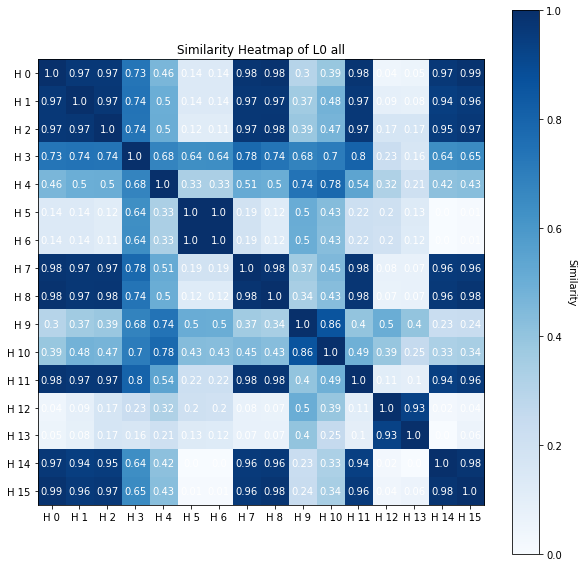

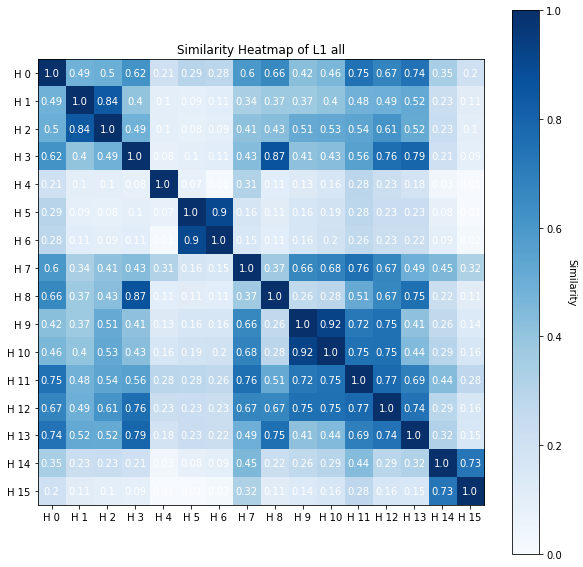

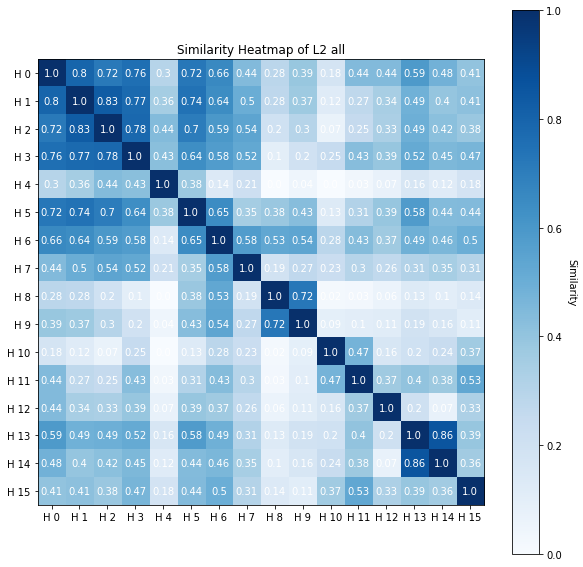

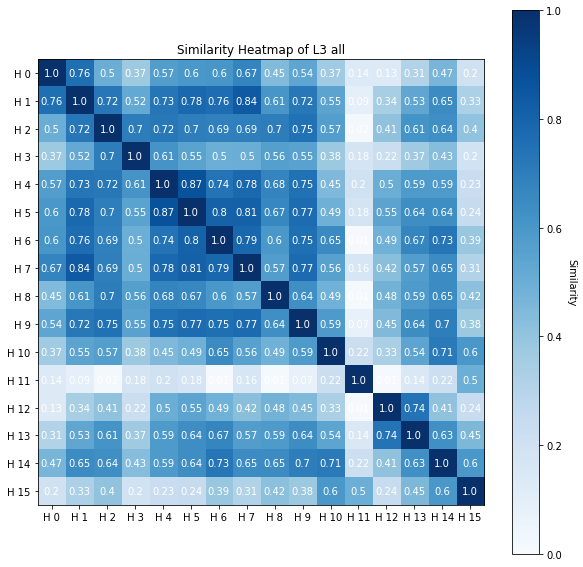

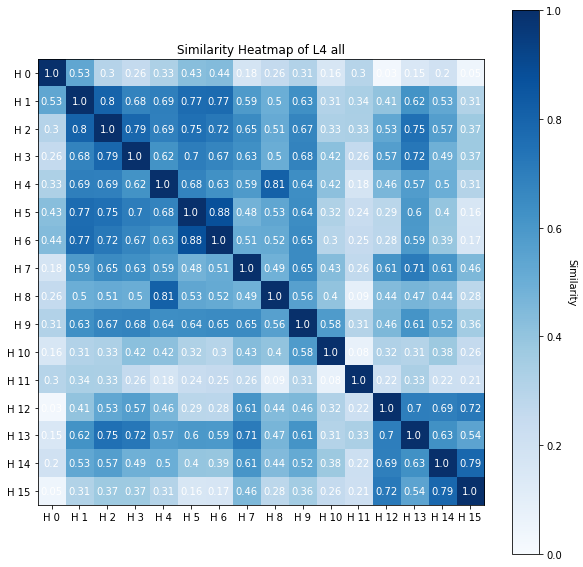

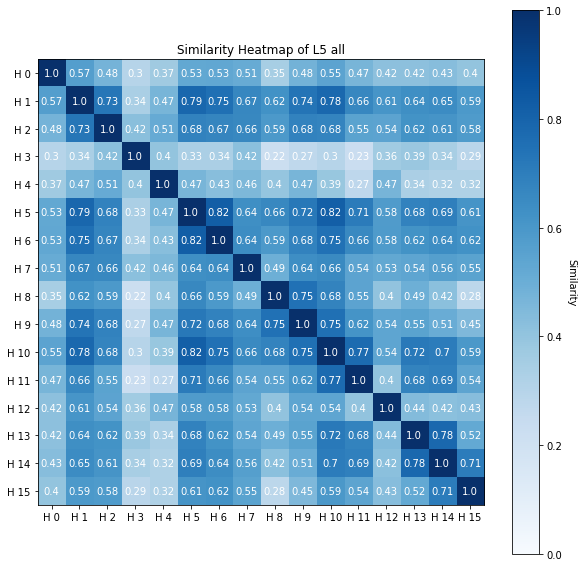

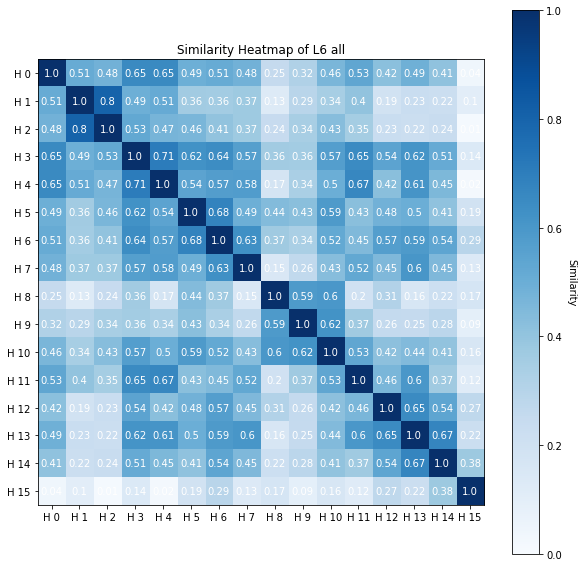

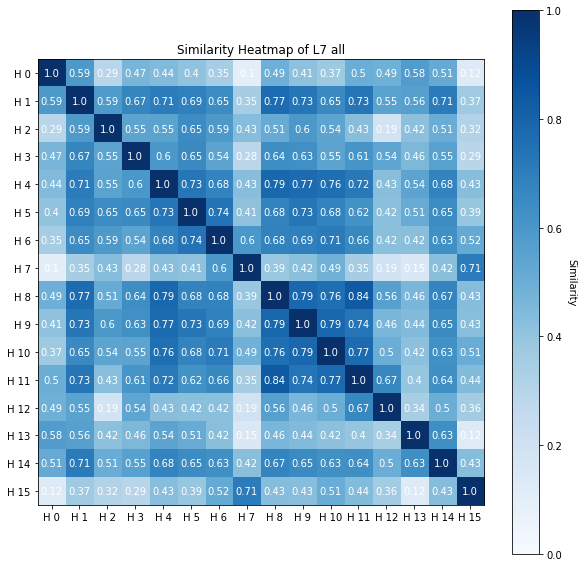

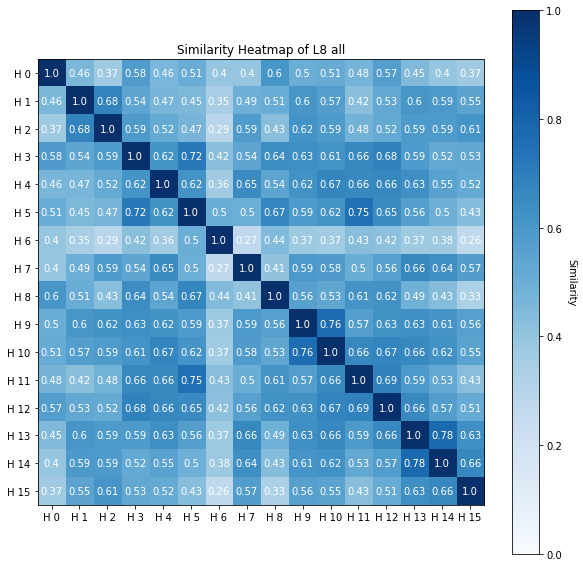

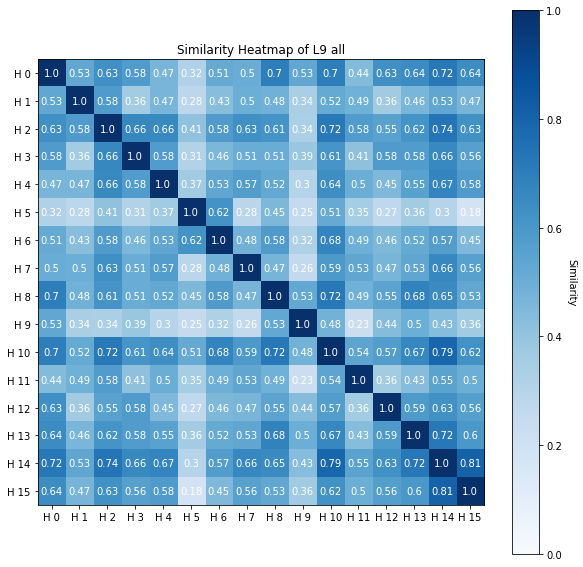

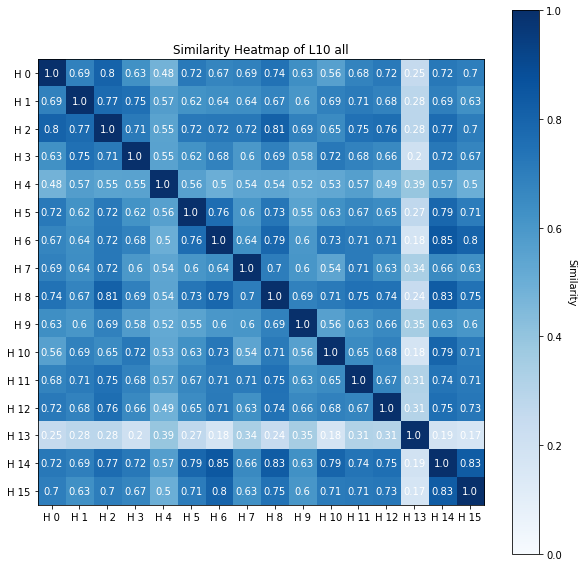

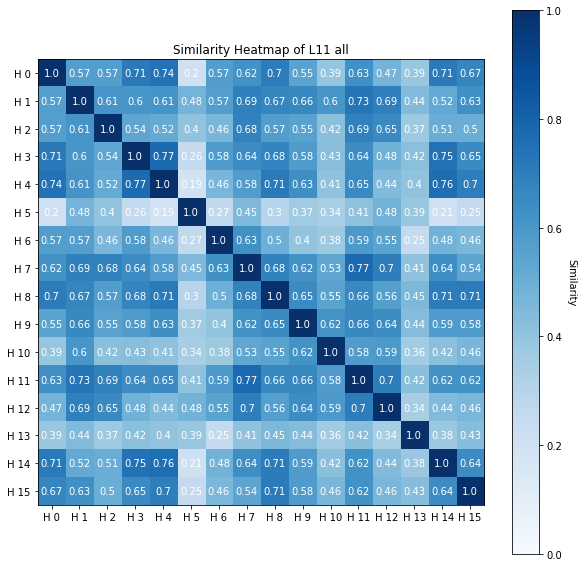

In [7]:
# 我想在如下代码上就行改进，使得生成的12个热力图变成动图
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
# show_list = []
# fig = plt.figure(dpi=70)
def hotmap(layer, type="all", head_num=12, draw=True, Vmin=0, Vmax=1):
    sims = np.zeros((head_num, head_num))
    # 计算两两之间的相似度
    for i in range(head_num):
        for j in range(i, head_num):
            if type == "all":
                sims[i, j] = all_cca(layer, i, layer, j, draw=False, isprint=False)
            elif type == "cos":
                sims[i, j] = cos_sim(layer, i, layer, j, isprint=False)
            sims[j, i] = sims[i, j]


    # 画出热力图
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(sims, cmap='Blues')  # 'gist_rainbow'

    # 添加坐标轴标签和标题
    ax.set_xticks(np.arange(head_num))
    ax.set_yticks(np.arange(head_num))
    ax.set_xticklabels(['H {}'.format(i) for i in range(head_num)])
    ax.set_yticklabels(['H {}'.format(i) for i in range(head_num)])
    ax.set_title('Similarity Heatmap of L%d ' % (layer) + type)

    # 添加数值到热力图中
    for i in range(head_num):
        for j in range(head_num):
            text = ax.text(j, i, round(sims[i, j], 2), ha='center', va='center', color='w')

    # 添加colorbar
    im.set_clim(Vmin, Vmax)
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel('Similarity', rotation=-90, va='bottom')

    # 展示图像
    plt.show()
    # show_list.append([plt.imshow(im, cmap='gray')])

for i in range(12):
    hotmap(i, type="all", head_num=head_num, Vmin=0.0, Vmax=1.0)
    # hotmap(i, type="cos", Vmin=0.0, Vmax=1.0)
# ani = animation.ArtistAnimation(fig, show_list, interval=1000, repeat_delay=1000, blit=True)


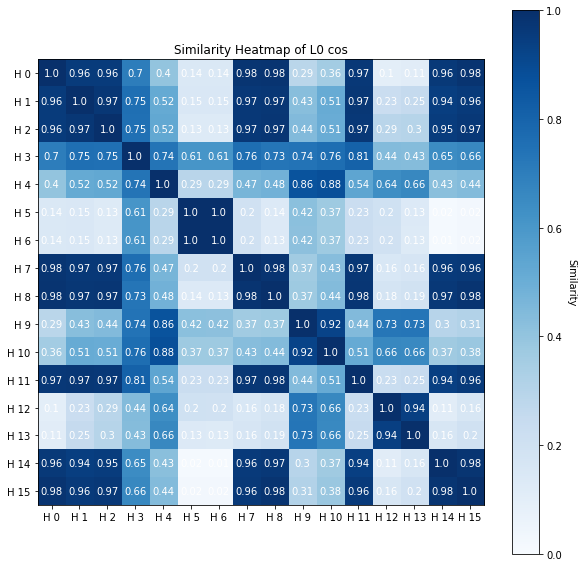

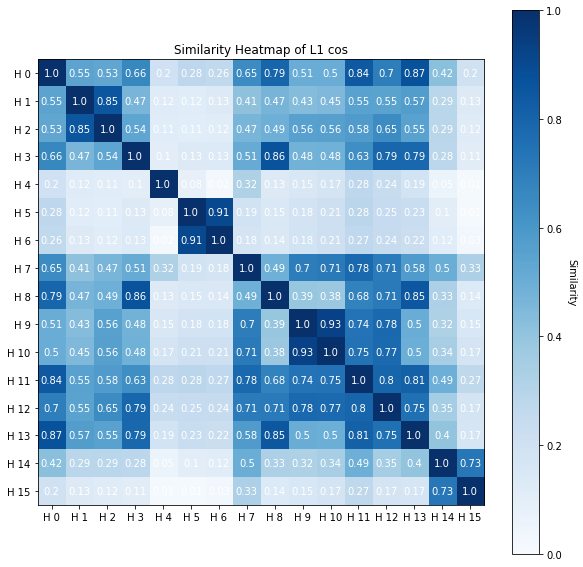

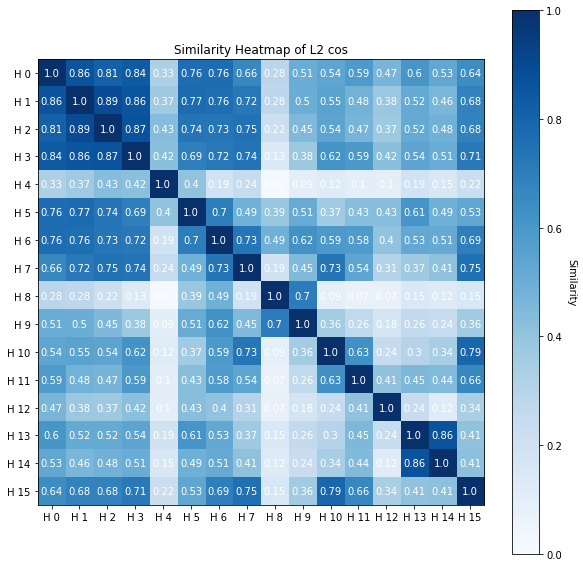

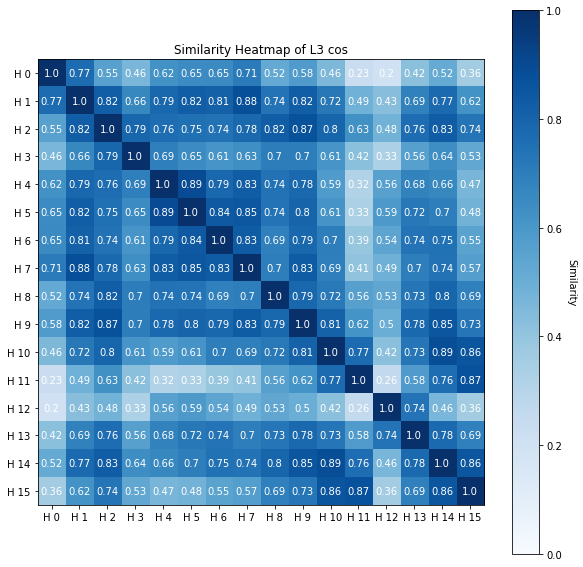

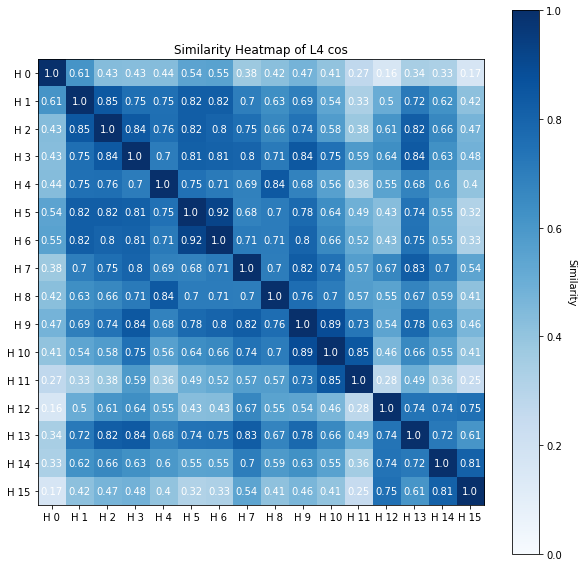

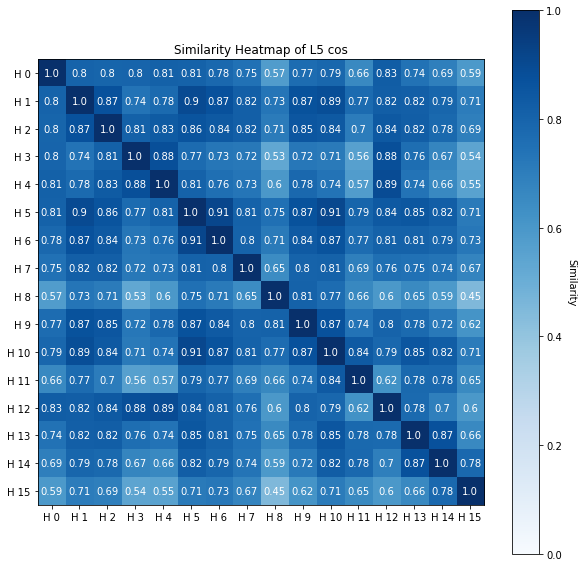

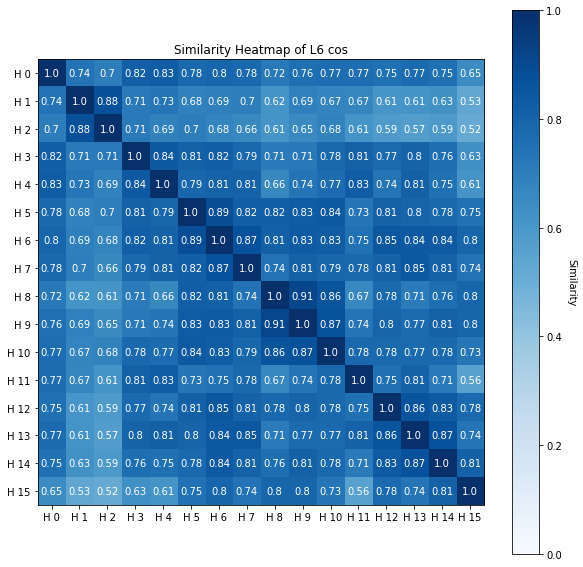

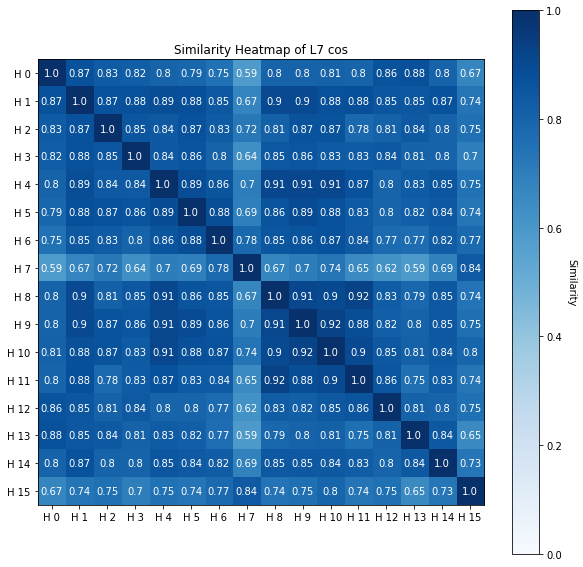

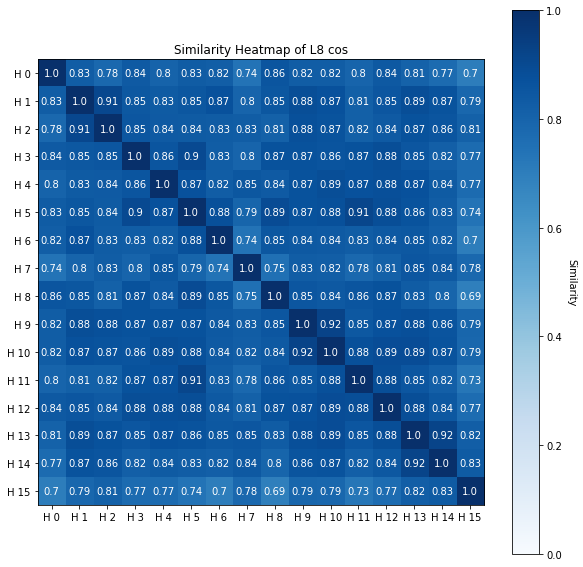

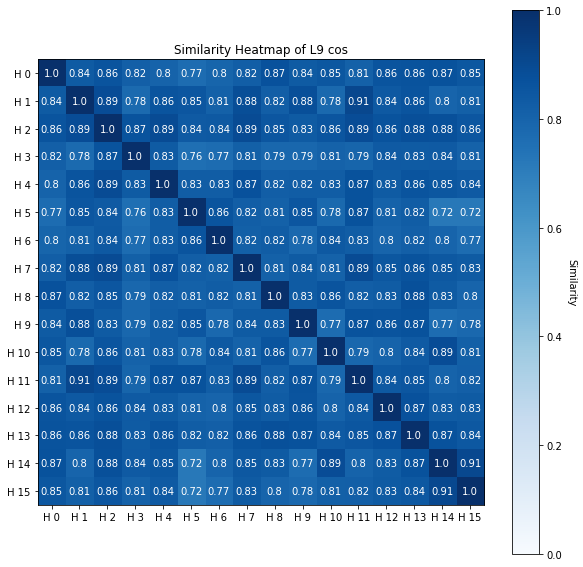

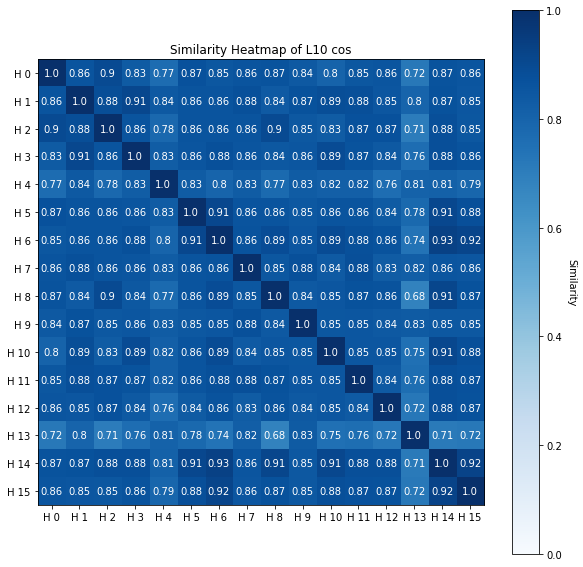

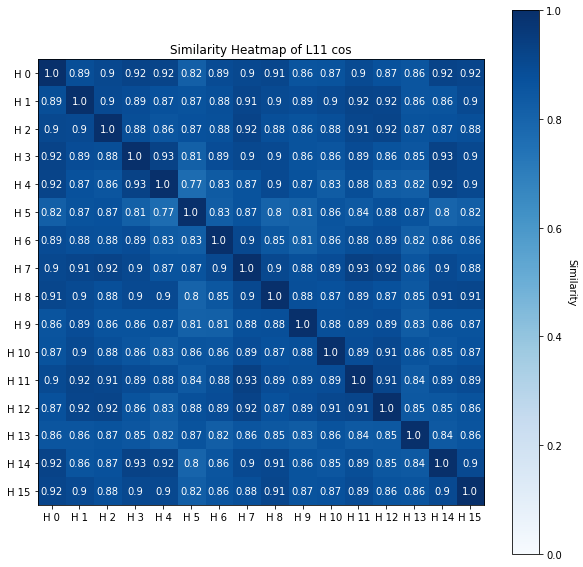

In [9]:
for i in range(12):
    # hotmap(i, type="all", head_num=head_num, Vmin=0.0, Vmax=1.0)
    hotmap(i, type="cos", head_num=head_num, Vmin=0.0, Vmax=1.0)

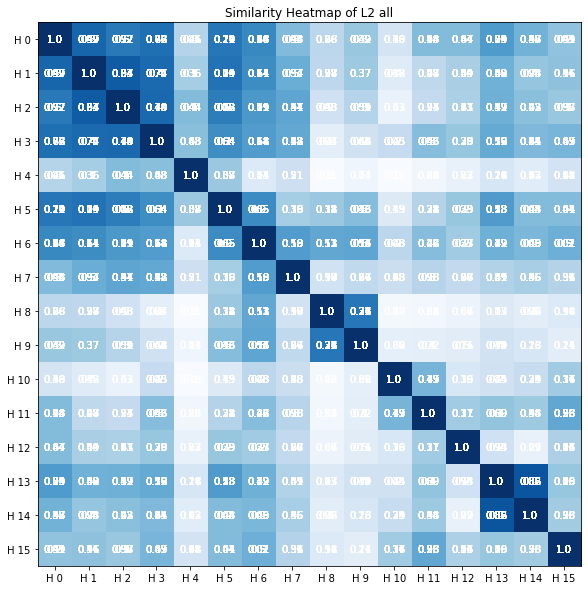

In [17]:
# 我想在如下代码上就行改进，使得生成的12个热力图变成动图
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
show_list = []
# fig = plt.figure(dpi=70)
fig, ax = plt.subplots(figsize=(10, 10))
# 添加坐标轴标签和标题
ax.set_xticks(np.arange(head_num))
ax.set_yticks(np.arange(head_num))
ax.set_xticklabels(['H {}'.format(i) for i in range(head_num)])
ax.set_yticklabels(['H {}'.format(i) for i in range(head_num)])
def hotmap(layer, type="all", head_num=12, draw=True, Vmin=0, Vmax=1):
    sims = np.zeros((head_num, head_num))
    # 计算两两之间的相似度
    for i in range(head_num):
        for j in range(i, head_num):
            if type == "all":
                sims[i, j] = all_cca(layer, i, layer, j, draw=False, isprint=False)
            elif type == "cos":
                sims[i, j] = cos_sim(layer, i, layer, j, isprint=False)
            sims[j, i] = sims[i, j]


    # 画出热力图
    ax.set_title('Similarity Heatmap of L%d ' % (layer) + type)
    # 添加数值到热力图中
    for i in range(head_num):
        for j in range(head_num):
            text = ax.text(j, i, round(sims[i, j], 2), ha='center', va='center', color='w')
    
    im = ax.imshow(sims, cmap='Blues')  # 'gist_rainbow'
    return im



    # # 添加colorbar
    # im.set_clim(Vmin, Vmax)
    # cbar = ax.figure.colorbar(im, ax=ax)
    # cbar.ax.set_ylabel('Similarity', rotation=-90, va='bottom')

    # # 展示图像
    # plt.show()
    # # show_list.append([plt.imshow(im, cmap='gray')])

for i in range(2):
    # frame = []
    for j in range(10):
        show_list.append([hotmap(i, type="all", head_num=head_num, Vmin=0.0, Vmax=1.0)])
# hotmap(0, type="all", head_num=head_num, Vmin=0.0, Vmax=1.0)
# hotmap(1, type="all", head_num=head_num, Vmin=0.0, Vmax=1.0)
# hotmap(2, type="all", head_num=head_num, Vmin=0.0, Vmax=1.0)
ani = animation.ArtistAnimation(fig=fig, artists=show_list, repeat=False, interval=500, repeat_delay=500)
ani.save('2.gif', fps=30)
# ani = animation.ArtistAnimation(fig, show_list, interval=1000, repeat_delay=1000, blit=True)


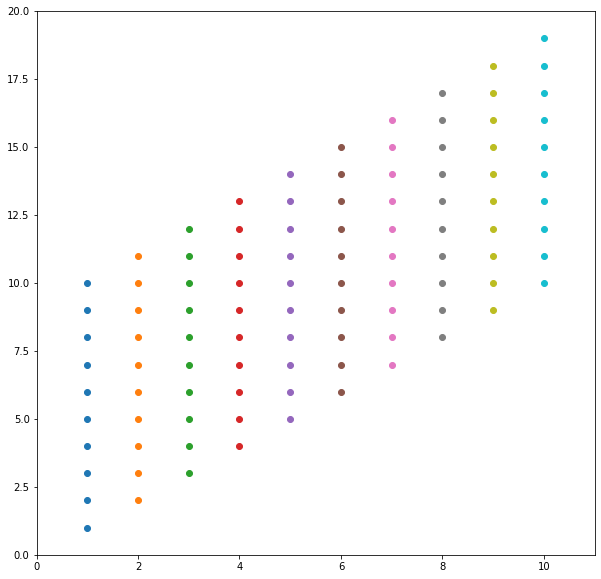

In [14]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

x = [1,2,3,4,5,6,7,8,9,10]
y = [1,2,3,4,5,6,7,8,9,10]

fig, ax = plt.subplots(figsize=(10, 10))
plt.xlim(0, 11)
plt.ylim(0, 20)

show_list = []
# 总共10帧，每帧10个点
for i in range(10):
    frame = []
    for j in range(10):
        frame += plt.plot(x[j], y[j]+i, "o")    # 注意这里要+=，对列表操作而不是appand
        # show_list.append(frame)
        show_list.append([ax.imshow(sims, cmap='Blues')])

ani = animation.ArtistAnimation(fig=fig, show_list=show_list, repeat=False, interval=10)
plt.show()
ani.save('2.gif', fps=30)
